## Q-learning (off-policy TD Control) for Continous State Spaces

Resources used while writing this notebook:
- [Nimish Sanghi's book on Deep RL](https://www.amazon.com/Deep-Reinforcement-Learning-Python-TensorFlow/dp/1484268083)

Some info about the CartPole environment:

A pole is attached to a cart which moves on a frictionless surface. The pole starts upright at the start of episode. The goal is to prevent the pole from falling by increasing or decreasing the velocity of the cart. 

Observation Space $\; \rightarrow \; $ (Cart position, Cart velocity, Pole angle, Pole angular velocity):
- x-position: from -4.8 to 4.8
- x-velocity: from -$\infty$ to $\infty$
- pole-angle: from $-24^{\circ}$ (or $\approx -0.418$ rad) to $24^{\circ}$ (or $\approx 0.418$ rad)
- pole angular velocity: from -$\infty$ to $\infty$

Action Space: The agent can either take action 0 or action 1, indicating the direction of the fixed force the cart is pushed with.
- 0 $\; \rightarrow \;$ Push cart to the left
- 1 $\; \rightarrow \;$ Push cart to the right

Rewards: Since the goal is to keep the pole upright for as long as possible, by default, a reward of +1 is given for every step taken, including the termination step. The agent wants to maximize reward by keep pole balanced for longest time interval. The episode terminates once the pole angle is more than $12^{\circ}$  in either direction or the cart position is beyond 2.4 from the center, i.e., either less than -2.4 or greater than 2.4. In addition, the episode ends when the agent is able to keep the pole upright for 500 steps continuously.

In [24]:
import gymnasium as gym
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Image

%matplotlib inline

In [25]:
class Q_Learning:
    """Q-learning (off-policy TD control) algorithm."""
    def __init__(self, get_possible_actions, strategy, 
                 epsilon=1, alpha=1, gamma=1):
        self._Q = defaultdict(lambda: defaultdict(lambda: 0))
        self.get_possible_actions = get_possible_actions
        self.epsilon = epsilon
        self.strategy = strategy
        self.alpha = alpha   # learning rate or step size
        self.gamma = gamma   # discount factor


    def _get_Q(self, state, action):
        return self._Q[state][action]


    def set_Q(self, state, action, value):
        self._Q[state][action] = value


    def update(self, state, action, reward, next_state, done):
        """
        This is the main update function for the Q-learning algorithm.
        Note that this function only contains the update equations, 
        not the entire Q-learning algorithm.
        """
        if not done:
            best_next_action = self.max_action(next_state)
            td_error = reward + \
                       self.gamma * self._get_Q(next_state, best_next_action) - \
                       self._get_Q(state, action)
        else:
            td_error = reward - self._get_Q(state, action)
        q_value = self._get_Q(state, action) + self.alpha * td_error
        self.set_Q(state, action, q_value)


    def max_action(self, state):
        """
        Return the best action for a given state, ie,
        the action in the state-action pair that has the highest Q-value.
        If there are multiple actions with the same Q-value,
        return a random action from the set of best actions.
        """
        actions = self.get_possible_actions(state)
        best_action = []
        best_q_value = float("-inf")
        for action in actions:
            q_value = self._get_Q(state, action)
            if q_value > best_q_value:
                best_action = [action]
                best_q_value = q_value
            elif q_value == best_q_value:
                best_action.append(action)
        return np.random.choice(np.array(best_action))


    def get_action(self, state):
        """
        Choose an action based on the input strategy.
        """
        return self.strategy(self.epsilon, self.get_possible_actions,
                             state, self.max_action)



In [26]:
def epsilon_greedy_strategy(epsilon, get_possible_actions, state, max_action):
    """
    Epsilon-greedy strategy.

    Choose a random number in the interval [0, 1) with a uniform 
    probability distribution. Use np.random.random() to do this.

    If this random number is less than epsilon, return a random action.
    Otherwise, return the best action for the given state.
    """
    actions = get_possible_actions(state)
    if len(actions) == 0:
        return None
    random_number = np.random.random()
    if random_number < epsilon:
        # exploration
        return np.random.choice(actions)
    else:
        # exploitation
        return max_action(state)
    

In [27]:
class ReplayBuffer:
    def __init__(self, size):
        """
        :param size: maximum number of items in the buffer
        """
        self.size = size
        self.buffer = []  # list to store the items

    def __len__(self):
        return len(self.buffer)
    
    def add(self, state, action, reward, next_state, done):
        """
        Add a new item to the buffer.
        If the buffer is full, remove the oldest item.
        """
        item = (state, action, reward, next_state, done)
        self.buffer = self.buffer[-self.size:] + [item]

    def sample(self, batch_size):
        """
        Sample a batch of items from the buffer.
        """
        idxs = np.random.choice(len(self.buffer), batch_size)
        samples = [self.buffer[i] for i in idxs]
        state, action, reward, next_state, done_flag = list(zip(*samples))
        return state, action, reward, next_state, done_flag


In [28]:
def train_agent(env, agent, num_episodes=10_000, t_max=10_000, decay_rate=None,
                replay_buffer=None, batch_size=16):
    """
    This is a generic training function.

    env: gymnasium environment
    agent: Q_Learning object
    num_episodes: (int) number of episodes to train the agent
    t_max: (int) maximum number of steps per episode
    decay_rate: (float) epsilon decay rate
    replay_buffer: ReplayBuffer object
    batch_size: (int) batch size for experience replay
    """
    episode_rewards = []
    for i in tqdm(range(num_episodes)):
        G = 0
        state, _ = env.reset()
        for t in range(t_max):
            action = agent.get_action(state)
            next_state, reward, done, trunc, _ = env.step(action)
            flag = (done or trunc)
            if replay_buffer is not None:
                replay_buffer.add(state, action, reward, next_state, flag)
                states, actions, rewards, next_states, done_flags = \
                    replay_buffer.sample(batch_size)
                for i in range(batch_size):
                    agent.update(states[i], actions[i], rewards[i],
                                 next_states[i], done_flags[i])
            else:
                agent.update(state, action, reward, next_state, flag)
            G += reward
            if flag:
                episode_rewards.append(G)
                if decay_rate is not None:
                    agent.epsilon = agent.epsilon * decay_rate
                break
            state = next_state
    return np.array(episode_rewards)


In [29]:
def plot_rewards(env_name, rewards, label):
    plt.title(f"Env: {env_name}  Mean Reward: {np.mean(rewards[-20:]):.1f}")
    plt.plot(rewards, label=label)
    plt.grid()
    plt.legend()
    plt.show()


`Observation Wrapper`: https://gymnasium.farama.org/api/wrappers/observation_wrappers/#gymnasium.ObservationWrapper.observation

In [31]:
from gymnasium import ObservationWrapper

class Discretizer(ObservationWrapper):
    """
    We will use ObservationWrapper class from gym to wrap our environment.
    We need to implement observation() method which will receive the
    original state values from underlying environment.
    In observation() we will discretize the state values, which then
    will be passed to outside world by env. 
    The agent will use these discrete state values to learn an 
    effective policy using Q-learning.
    """
    def observation(self, state):
        discrete_x_pos = round(state[0], 1)
        discrete_x_vel = round(state[1], 1)
        discrete_pole_angle = round(state[2], 1)
        discrete_pole_ang_vel = round(state[3], 1)

        return (discrete_x_pos, discrete_x_vel,
                discrete_pole_angle, discrete_pole_ang_vel)
    

### Trying out Q-learning on CartPole environment

Check out the [environment page](https://gymnasium.farama.org/environments/classic_control/cart_pole/) for description about it.

In [2]:
Image(url="https://gymnasium.farama.org/_images/cart_pole.gif")

In [3]:
env = gym.make("CartPole-v1")

In [4]:
state, _ = env.reset()
state

array([ 0.02846489, -0.01901361, -0.0252371 ,  0.02659684], dtype=float32)

In [13]:
env.observation_space.shape

(4,)

In [11]:
env.action_space.n

2

In [32]:
# wrap our environment with Discretizer
env = Discretizer(env)

In [51]:
state, _ = env.reset()
state

(-0.0, -0.0, 0.0, -0.0)

In [37]:
env.observation_space.shape

(4,)

In [35]:
env.action_space.n

2

In [52]:
# create a Q Learning agent
agent = Q_Learning(alpha=0.5, epsilon=0.2, gamma=0.99, 
                   get_possible_actions=lambda s : range(env.action_space.n),
                   strategy=epsilon_greedy_strategy)

# train agent using replay buffer and get rewards for episodes
rewards = train_agent(env, agent, num_episodes=5000, 
                      replay_buffer=ReplayBuffer(512), decay_rate=0.99)

100%|██████████| 5000/5000 [04:12<00:00, 19.81it/s]


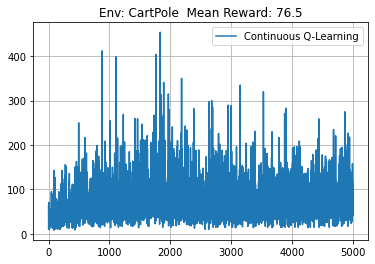

In [53]:
plot_rewards("CartPole", rewards, "Continuous Q-Learning")

In [54]:
def fn():
    action_dict = {
        0: "LEFT",
        1: "RIGHT"
    }
    state, _ = env.reset()
    print(f"state: {state}")
    while True:
        best_action = agent.max_action(state)
        print(f"best_action: {action_dict[best_action]}")
        next_state, reward, done, trunc, _ = env.step(best_action)
        if done or trunc:
            print(f"Terminal state reached.\nState: {next_state}")
            break
        state = next_state
        print(f"state: {state}")

fn()

state: (-0.0, -0.0, -0.0, -0.0)
best_action: LEFT
state: (-0.0, -0.2, -0.0, 0.3)
best_action: LEFT
state: (-0.0, -0.4, -0.0, 0.6)
best_action: RIGHT
state: (-0.0, -0.2, -0.0, 0.3)
best_action: LEFT
state: (-0.0, -0.4, -0.0, 0.5)
best_action: RIGHT
state: (-0.0, -0.2, 0.0, 0.3)
best_action: LEFT
state: (-0.0, -0.4, 0.0, 0.5)
best_action: RIGHT
state: (-0.0, -0.2, 0.0, 0.3)
best_action: LEFT
state: (-0.1, -0.4, 0.0, 0.6)
best_action: RIGHT
state: (-0.1, -0.2, 0.0, 0.3)
best_action: RIGHT
state: (-0.1, -0.0, 0.0, -0.0)
best_action: RIGHT
state: (-0.1, 0.2, 0.0, -0.3)
best_action: RIGHT
state: (-0.1, 0.4, 0.0, -0.6)
best_action: LEFT
state: (-0.1, 0.2, 0.0, -0.3)
best_action: RIGHT
state: (-0.0, 0.4, 0.0, -0.5)
best_action: LEFT
state: (-0.0, 0.2, 0.0, -0.2)
best_action: LEFT
state: (-0.0, -0.0, 0.0, 0.1)
best_action: RIGHT
state: (-0.0, 0.2, 0.0, -0.2)
best_action: LEFT
state: (-0.0, -0.0, 0.0, 0.1)
best_action: RIGHT
state: (-0.0, 0.2, 0.0, -0.2)
best_action: LEFT
state: (-0.0, -0.0, -0.